# <u>Dog Classifier 

In [1]:
import tensorflow as tf  
import numpy as np     
import os
import cv2
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

#All dependenices imported for making the model

2024-08-16 21:04:41.666326: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-16 21:04:41.666944: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-16 21:04:41.669400: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-16 21:04:41.676416: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 21:04:41.687877: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

## <u>Obtaining data

In [2]:
tf.data.Dataset

tensorflow.python.data.ops.dataset_ops.DatasetV2

In [3]:
data = tf.keras.utils.image_dataset_from_directory('data')   #this loads all data from the 'data' file
                                                             #The data file has images of both my dogs, Liz (the German Shepard) and Todo
                                                             # (a German shepard and lab mix). This line combines all 205 photos taken
                                                             # by me into one data variable 

Found 205 files belonging to 2 classes.


In [4]:
data_iterator = data.as_numpy_iterator()                     #iterator to go through all the photos

In [5]:
batch = data_iterator.next()                                 #get the first batch of photos (which happen to be of Liz)

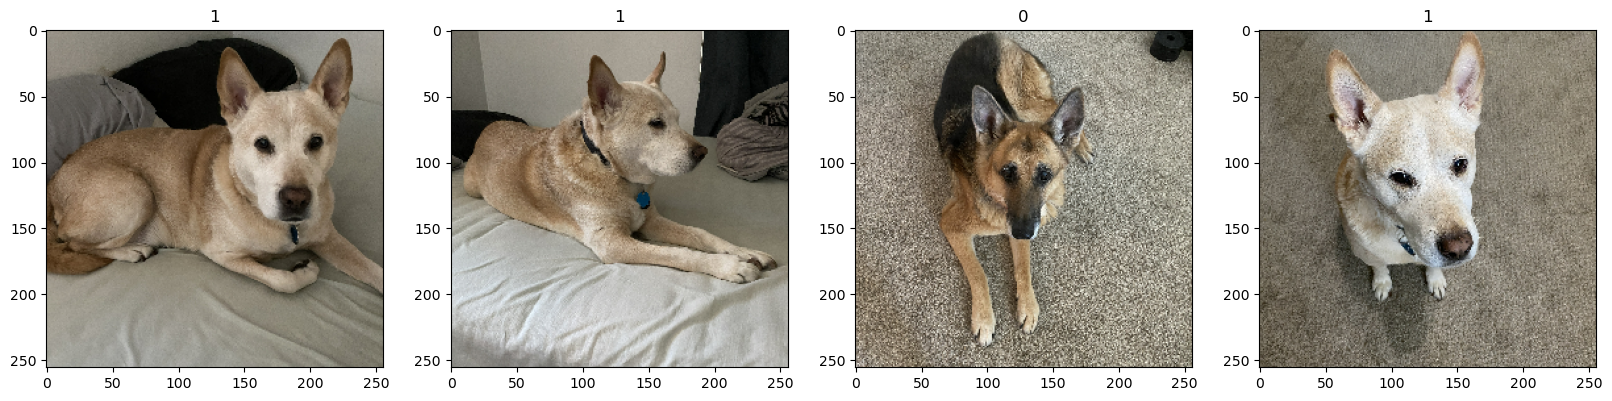

In [6]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))            #get the first four same images and show them
for idx, img in enumerate(batch[0][:4]):                    #Note that the 0 flag is Liz, and the 1 flag is Todo
    ax[idx].imshow(img.astype(int))       #show image
    ax[idx].title.set_text(batch[1][idx]) #print the label

#Note that each image is 256x256

In [7]:
# **Bruh moment

In [8]:
data = data.map(lambda x,y: (x/255, y))           #Normalize each image pixel from 0 to 1 instead of 0 to 255
                                                  #To normalize (in math) means to make a value to be in the range of 0 to 1. 
                                                  #We do this because smaller values are much easier to work on and is standard pratice
                                                  #We can easily normalize each pixel value by dividing by the max value that a single RGB
                                                  #value can take (which is 255) (this is called min-max normalization)

## <u>Preprocessing

We need to separate batches for our training, testing, and validation data to train the model and evaluate performance. There are 7 total batches

In [9]:
#Reserve about 70% of our data for testing, 20% for validation, and 10% for testing
train_size = int(len(data)*0.7)           #Results in 4 batches of data for training       
val_size = int(len(data)*0.2) + 1         #2 batches for validation data
test_size = int(len(data)*0.1) + 1        #1 batch for testing data

#### About training, validation, and testing data

Training data is the data that the model uses to extract patterns and features about the images to be able to generalize and classify other, unseen images correctly. (A feature is something quantifiable about the image. In this case, the intensity or color of a pixel is one example that this model might use to train

Validation data is used to evaluate the model during training after each epoch. An epoch is one pass through all the training data in one cycle. In this case, the model will go through 20 epochs, meaning it will see all the training data 20 times when training. Validation data helps prevent overfitting. Overfitting is essentially when the model learns the training data too well such that it can't correctly identify other unseen data

Testing data is used to evaluate the performance of our model. Basically, it's asking "How well did the model pick up on patterns and features from the training data to be able to correctly classify other unseen data?"

In [10]:
train = data.take(train_size)                                    #Take images for the training data
val = data.skip(train_size).take(val_size)                       #Skip over the images we took for training data and take images 
                                                                 #for the validation set
test = data.skip(train_size + val_size).take(test_size)          #Similar idea except for both the training and validation sets for testing

## Making the model

Firstly, lets talk about what a CNN is. A Convolutional Neural Network is a type of network that is quite good in image classification since it can recognize patterns and features in images. It's composed of a bunch of "layers", which are essentially "filters" that recognize a specific pattern, such as edges, certain shapes, or colors. The early layers recognize might simple patterns while later layers can identify more complex features or even entire objects. The "filters" in the convolutional layers scan over the image and detect these features. 

In [11]:
model = Sequential()    #this declares a sequential CNN model. A sequential model stacks the layers linear order (like
                        #stacking books). It's one of the more simpler models and is best for basic classification tasks. There are other
                        #more complex models that might stack and connect layers differently, but I chose a sequential model since it's 
                        #perfectly fine for this simple task and implementing a more complex model would likely be overkill

In [12]:
#this model has 9 total layers.

#A Conv2D layer is a layer that processes 2D images and extract features from those images
#Here's what the stuff in the parenthesis mean: Make 16 filters to detect features in the image using small 3x3 windows to slide over the 
#image to detect them and move 1 pixel each time. If you encounter a negative value while doing your math, set it to zero and leave other 
#positive values alone (the 'relu' part, rectified linear unit is what does this). 
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3) ))   #note that the first layer has to specify the expected shape
                                                                               #of the input data
model.add(MaxPooling2D())  #A max pooling layer basically reduces the size of the image while trying to keep the most important features
                           #Not using a layer like this would make for a very large amount of features, which take a lot of processing time
                           #and may potentially overfit data (learning the training data too well such that it can't perform well on others)

model.add(Conv2D(32, (3,3), 1, activation='relu'))      #same idea with these 4 layers
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())


model.add(Flatten())   #A flatten layer is exactly what it sounds like. All the stuff we did before was in 2D, but we now have to flatten
                       #down to 1D because the next layer (the Dense layer) requires the input to be in 1D

model.add(Dense(256, activation='relu'))      #In the dense layer, the model comes to a conclusion and actually classifies the data.
                                              #It takes all the computations made by the previous layers to make a prediction. In this case,
                                              #it takes 256 neurons (which is like a tiny decision maker that takes a small part of an image 
                                              #and processes the feature) to come to a decision

model.add(Dense(1, activation='sigmoid'))     #This is the final dense layer that makes the classifcation, this time using a sigmoid function.
                                              #It uses just one neuron to output a value and uses a sigmoid function. A sigmoid function 
                                              #essentially squashes that value to be between 0 (for Liz) and 1 (for Todo) 

/home/matt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(),metrics=['accuracy'])

#essentially, this line optimizes the model to have the least amount of loss (how far off the prediction was from the correct answer) 
#and tracks the accuracy

In [14]:
model.summary()   #summary of all the layers we used and how many parameters (weights and other variables) used in each one

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

## Training the model

We've made the model, now let's actually train it

In [15]:
logdir='logs'   #make a directory to save all the activity in training the model

In [16]:
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir)   #make a callback to log training data

In [17]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

#We now can actually train the model. We pass the validation data, the callback to log the data, and we specify the number of epochs.
#As stated before, a epoch is a complete pass of the training data. We don't want to make to few passes (underfitting, which is when the
#model doesn't learn enough to be able to generalize and correctly classify data outside or even in the training data) or to many passes
#(which results in overfitting)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 406ms/step - accuracy: 0.5146 - loss: 1.2323 - val_accuracy: 0.5000 - val_loss: 1.0131
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 438ms/step - accuracy: 0.4781 - loss: 0.9097 - val_accuracy: 0.4844 - val_loss: 0.6781
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 425ms/step - accuracy: 0.4938 - loss: 0.6785 - val_accuracy: 0.7969 - val_loss: 0.6535
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 428ms/step - accuracy: 0.8479 - loss: 0.6375 - val_accuracy: 0.7344 - val_loss: 0.5881
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 439ms/step - accuracy: 0.7177 - loss: 0.5650 - val_accuracy: 0.7500 - val_loss: 0.5174
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 436ms/step - accuracy: 0.7688 - loss: 0.5017 - val_accuracy: 0.9375 - val_loss: 0.4247
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 438ms/step - accuracy: 0.9271 - loss: 0.4017 - val_accuracy: 0.9375 - val_loss: 0.2980
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 436ms/step - accuracy: 0.9104 - loss: 0.2699 - val_accuracy: 0.9219 - val_loss:

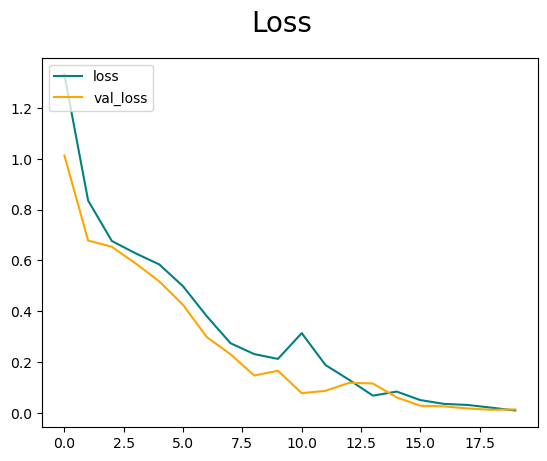

In [18]:
fig=plt.figure()                            
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

#This graphs the validation and training loss functions (how far the model is off from the correct answer). Both are trending downward 
#in the same direction which is good because that means there's no overfitting (loss does down but val_loss goes up) nor underfitting
#(both loss and val_loss lines go upward)

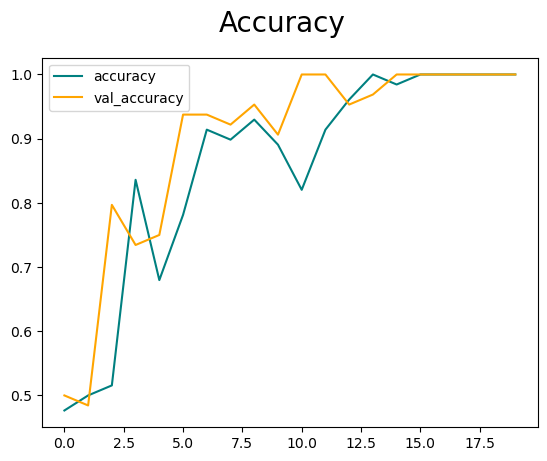

In [19]:
fig=plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

#Same idea as previously except with accuracy. This time we want both of the lines to be trending upward, since we want the model to be 
#accurate on both datasets

## Evaluating the performance

In [20]:
pre = Precision()                 
re = Recall()
acc = BinaryAccuracy()

#Finding the precision (ratio of correctly predicted positive answers to total positive answers that were in the dataset), 
#recall (ratio of correct positive predictions to total positive answers),
#and accuracy (ratio of correct predictions to total number of predictions)

In [25]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

#obtain the precision, recall, and accuracy

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [22]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

#print it out

Precision: 1.0, Recall: 1.0, Accuracy: 1.0


In [23]:
#model.save(os.path.join('model', 'dogclassifier.keras'))   #save the model for use later

                                                            #this was used in a computer vision section of this project